MLP for classification
Binary Classification with MLP
We will build up a MLP from scratch and determine what each step of the network is doing.
The aim of this exercise is to experiment with MLPs and to provide you a blueprint for your own data
projects.

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.autograd import Variable
#For the thyroid dataset we need the following imports:
from numpy import vstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
#For the built-in datasets from PyTorch we need the following imports:
from torchvision import datasets,transforms #import torchvision for datasets and transform
#You can additionally import the scikit-learn package for building up model metrics:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score,average_precision_score
from sklearn.metrics import confusion_matrix, recall_score, f1_score


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Outcome variable is thyroid_class this is 1=sick and 0=well
• The rest of the outcomes relate to measurements taken associated with thyroid disorders and
are explained in the documentation.
o Go to the URL: https://www.openml.org/search?type=data&sort=runs&id=57&status=active
o Download the .arff file of the hypothyroid dataset and save it to the directory of your Jupyter
notebook
o Run the following code to get the raw dataset as DataFrame:

    age   sex on_thyroxine query_on_thyroxine on_antithyroid_medication  sick  \
0  41.0  b'F'         b'f'               b'f'                      b'f'  b'f'   
1  23.0  b'F'         b'f'               b'f'                      b'f'  b'f'   
2  46.0  b'M'         b'f'               b'f'                      b'f'  b'f'   
3  70.0  b'F'         b't'               b'f'                      b'f'  b'f'   
4  70.0  b'F'         b'f'               b'f'                      b'f'  b'f'   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  ... TT4_measured  \
0     b'f'            b'f'           b'f'              b'f'  ...         b't'   
1     b'f'            b'f'           b'f'              b'f'  ...         b't'   
2     b'f'            b'f'           b'f'              b'f'  ...         b't'   
3     b'f'            b'f'           b'f'              b'f'  ...         b't'   
4     b'f'            b'f'           b'f'              b'f'  ...         b't'   

     TT4 T4U_measured   T4

<AxesSubplot: >

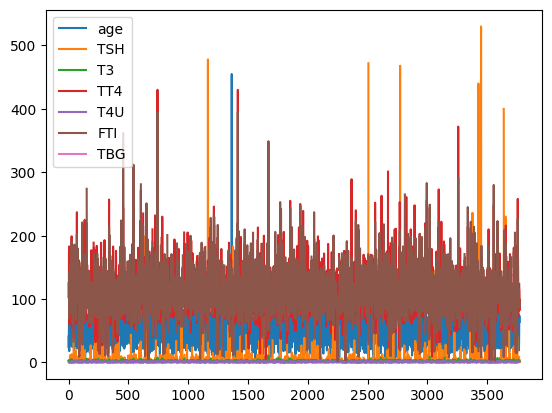

In [2]:
# load the data
from scipy.io.arff import loadarff
raw_data = loadarff("dataset_57_hypothyroid.arff")
df_data = pd.DataFrame(raw_data[0])

# Print the first 5 rows of df_data
# Print the dimensions of df_data
print(df_data.head(5))
print(df_data.shape)
print(list(df_data))

df_data.plot()

         0         1         2         3         4         5         6   \
0  0.840868  0.748013 -0.336622 -0.093813 -0.110187 -0.209816 -0.126011   
1  1.332229  0.748013 -0.336622 -0.093813 -0.110187 -0.209816 -0.126011   
2  0.644324  0.748013 -0.336622 -0.093813 -0.110187 -0.209816 -0.126011   
3  0.742596 -1.336875 -0.336622 -0.093813 -0.110187 -0.209816 -0.126011   
4  1.528773  0.748013 -0.336622 -0.093813 -0.110187 -0.209816 -0.126011   

         7         8         9   ...        17   18        19   20        21  \
0 -0.111865 -0.127492 -0.240146  ... -0.175318  0.0 -0.978221  0.0 -1.323796   
1 -0.111865 -0.127492 -0.240146  ... -0.116479  0.0 -1.708952  0.0 -0.788547   
2 -0.111865 -0.127492 -0.240146  ... -0.180088  0.0  0.239663  0.0  0.422805   
3 -0.111865 -0.127492 -0.240146  ... -0.108528  0.0 -0.491067  0.0 -0.704034   
4 -0.111865 -0.127492 -0.240146  ... -0.160210  0.0  0.239663  0.0  0.197438   

    22        23   24        25        26  
0  0.0 -0.638500  0.0 -1

<AxesSubplot: >

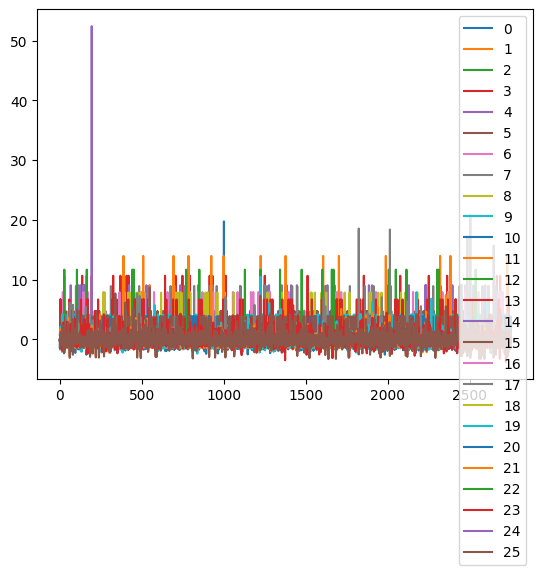

In [3]:
#Run the following code loading the dataset that we will be using and print the dimensions of df
#(cleansed data for the exercise):
df = read_csv('https://raw.githubusercontent.com/StatsGary/Data/main/thyroid_raw.csv',
header=None)


print(df.head(5))
print(df.shape)

df.plot()


The "df" data has no information presented about the metadata whereas "df_data" gives us also the important feature labels. With the 'class' or the 26th column, we get the outcome variable.

Step 01: Building the DataLoader for the dataset
This is how data loaders for different datasets can be produced.
We create the data loader to pull in CSV files. Therefore, we create a dataset class with one input Dataset (this is a specific PyTorch module that
works with various types of data).
Because we have tabular data, we will need to declare a reader to read in the file from the link to the raw data stored on GitHub and then we
will do some conversions:

In [4]:
from torch.utils.data import random_split
from torch.utils.data import Dataset


# Create a custom CSVDataset loader
class ThyroidCSVDataset(Dataset):
    #Constructor for initially loading
    def __init__(self,path):
        df = read_csv(path, header=None)
        # Store the inputs and outputs
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1] #Assuming your outcome variable is in this column

        self.X = self.X.astype('float32')
        # Label encode the target as values 1 and 0 or sick and not sick
        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))


    # Get the number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # Get a row at an index
    def __getitem__(self,idx):
        return [self.X[idx], self.y[idx]]


    # Create custom class method - instead of dunder methods
    def split_data(self, split_ratio=0.2):
        test_size = round(split_ratio * len(self.X))
        train_size = len(self.X) - test_size
        return random_split(self, [train_size, test_size])

What do we do here:
1) We have declared a class which will serve as our blueprint for all other types of data we may want to feed in. You could plug and play this
class into your own project and it would work. In this class we pass in an input called Dataset, as I have already explained, this is a special class
for dealing with PyTorch objects.
2) Next we declare a function using def __init__(). What this means is that when our class is used the first things the class needs are the
arguments contained in the function block. Essentially saving, this is what I need when the class is initialised. Within the parentheses we declare
two parameters – self and path (the location of the file).
3) What is this self parameter? Self represents the instance of the class. By using the “self” we can access the attributes and methods of the
class. Essentially, without this you would not be able to access the variables that belong to a class.
Within the __init__ function we do the following:
1) Use pandas to read the csv that is passed to the path
2) Set our independent variables to the variable X, but unlike normal functions, you need to make sure you use self.X. This assumed that the
data frames values are contained in every column but the last one, this slicing notation says df.values[:, :-1] take all my rows (:) and everything(:)
up to the last column (-1).
3) The same is done for the outcome variable, but this time we select just the last value [:,-1]Artificial Neural Networks and Deep Learning (II)
4) Next we convert the x value to a floating point value
5) We then turn sick and negative our outcome variables into numerical representations using the LabelEncoder() function from sklearn. This
just says if it is sick then give it a 1 otherwise 0. This is handy for quickly converting your target variables, as Python would not know what to do
with categorical features. Finally, we reshape to make sure it is in the right format for working with an n-dimensional array, in this case a tensor.
The __len__ and __getitem__ functions are dunder (magic) methods that every class has in Python. Here we have overridden the length method
to provide the number of rows in our training set and we have used the __getitem__ method to pull the relevant index position (idx) of the
relevant item. This will allow us to slice and retrieve elements.
The split_data function is a replication of the functionality of Scikit-Learn's train_test_split:
1) We have one parameter in this function split_ratio this indicates, as a proportion of the input data, how much data gets reserved for the
testing sample. This is the sample we will perform model evaluation on.
2) This then generates a training set, say if we chose to reserve 20% for testing, the other 80% of the observations will be used for model
training – the bit where the model picks out the patterns in the data based on the labelling (this is called supervised learning)
3) This returns a random split of the data, so each time you run this script you will have varying results, due to the random (let’s use the fancy
word stochastic) nature of the splits.

Step 02: Define our neural network model
We have told PyTorch so far how to read the data.
What we do next is tell the network how we want to model the data.
o Define the class called ThyroidMLP which inherits from Module
o In the __init__() method, define the parameters for the two fully connected layers.
o In the forward() method, do the forward step
The network structure should be:
1) Fully Connected Hidden Layer (n_inputs input features (number of features in X), 20 output features)
2) Fully Connected Hidden Layer (10 output features)
3) Output Layer (n_outputs output feature)
Use the ReLU for the activation function in the hidden layers.
Use the Sigmoid for the activation of the output layer

In [10]:

class ThyroidMLP(nn.Module):
    def __init__(self,n_inputs = 26, n_outputs = 1):
        super(ThyroidMLP,self).__init__()
        self.fc1 = nn.Linear(n_inputs,20)
        self.fc2 = nn.Linear(20,10)
        self.output = nn.Linear(10,n_outputs)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.output(x))

        return x

ThyroidMLP()

ThyroidMLP(
  (fc1): Linear(in_features=26, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=2, bias=True)
)

Model Training
Here we define how the model will train and update itself.
Last time, we used the cross entropy loss as loss function for our classification problem and Adam as
optimization algorithm with a learning rate of 0.01.
This was overly simplified, so today we will try to aim for something in the middle so that it is not too
complicated to fry our brains at this stage

In [11]:
import time
from torch.nn import BCELoss
from torch.optim import SGD


# Create training loop based off our custom class
def train_model(train_dl, model, epochs=100, lr=0.01, momentum=0.9):
    # Define your optimisation function for reducing loss when weights are calculated
    # and propogated through the network
    start = time.time()
    criterion = BCELoss()
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)
    loss = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        model.train()
        # Iterate through training data loader
        for i, (inputs, targets) in enumerate(train_dl):
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs.data,1) #Get the class labels
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        #torch.save(model, save_path)
    time_delta = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_delta // 60, time_delta % 60
    ))
    return model




There are five parameters to the model:
1) ThyroidCSVDataset this is the dataloader we created earlier
2) ThyroidMLP the model to be trained
3) 100 (optional) how many times do we want to feed through and back propagate errors. This is an optional parameter as the default is set to 100.
4) 0.01 (optional) learning rate - at what rate the model learns at. Too high a value and it misses key updates, too low and it can take forever. This is where
the *art* comes into Machine Learning.
5) momentum (optional) is used to speed up training
There are four key definitions in the training loop:
1) The start = time.time() parameter starts a timer, as we want to time how long our loop takes
2) The criterion = BCELoss() is how the loss will be calculated. Here we will use binary cross entropy (BCE Loss) for how the loss is computed
3) The  optimizer = SGD(model.parameters(), lr=lr, momentum=momentum) – how the loss is minimised via a process called gradient descent. We will use the random gradient descent, or stochastic gradient descent for
this
4) We default the loss = 0.0 to zero at the start to initialise the variable
The next step is to create the loop to loop through each epoch and start to train the model:
* We use a print statement to print the current epoch
* We set the model to train (model.train()) – this kicks off the training of the model
* We then iterate through our dataloader:
 * the optimiser is set to zero gradients, this is important to do, as the gradients can stay in cache and eat up memory
 * we pass the inputs into our model at every epoch
 * We use: _, preds = torch.max(outputs.data,1) to get the class labels from the outputs variable – which could be renamed to yhat – these are the predictions
 * The loss is passed to our chosen criterion – in this instance the binary cross entropy loss we discussed above
 * We then set the loss to back propagate through the network updating the weights as it goes i.e. loss.backward()
 * Then we need to tell the optimiser to start optimising the next step
 * At each step we save the model to a model path using torch.save – here you would want to really implement an if statement to check if this is the best model to
save
*Note: To use the GPU we would need to cast model.to(device) or model.to("cuda") for parallel processing.*


Step 04: Model Evaluation
Next we need to decide how we are going to evaluate the model.
The next function will be used to evaluate our PyTorch model to see if it is any good:

In [12]:
import math
def evaluate_model(test_dl, model, beta=1.0):
    preds = []
    actuals = []

    for (i, (inputs, targets)) in enumerate(test_dl):
        #Evaluate the model on the test set
        yhat = model(inputs)
        #Retrieve a numpy weights array
        yhat = yhat.detach().numpy()
        # Extract the weights using detach to get the numerical values in an ndarray, instead of tensor
        #https://www.tutorialspoint.com/how-to-convert-a-pytorch-tensor-with-gradient-to-a-numpy-array
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # Round to get the class value i.e. sick vs not sick
        yhat = yhat.round()
        # Store the predictions in the empty lists initialised at the start of the class
        preds.append(yhat)
        actuals.append(actual)


    # Stack the predictions and actual arrays vertically
    preds, actuals = vstack(preds), vstack(actuals)
    #Calculate metrics
    cm = confusion_matrix(actuals, preds)
    # Get descriptions of tp, tn, fp, fn
    tn, fp, fn, tp = cm.ravel()
    total = sum(cm.ravel())

    metrics = {
            'accuracy': accuracy_score(actuals, preds),
            'AU_ROC': roc_auc_score(actuals, preds),
            'f1_score': f1_score(actuals, preds),
            'average_precision_score': average_precision_score(actuals, preds),
            'f_beta': ((1+beta**2) * precision_score(actuals, preds) * recall_score(actuals, preds)) / 
            (beta**2 * precision_score(actuals, preds) + recall_score(actuals, preds)),
            'matthews_correlation_coefficient': (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)),
            'precision': precision_score(actuals, preds),
            'recall': recall_score(actuals, preds),
            'true_positive_rate_TPR':recall_score(actuals, preds),
            'false_positive_rate_FPR':fp / (fp + tn) ,
            'false_discovery_rate': fp / (fp +tp),
            'false_negative_rate': fn / (fn + tp) ,
            'negative_predictive_value': tn / (tn+fn),
            'misclassification_error_rate': (fp+fn)/total ,
            'sensitivity': tp / (tp + fn),
            'specificity': tn / (tn + fp),
            #'confusion_matrix': confusion_matrix(actuals, preds), 
            'TP': tp,
            'FP': fp, 
            'FN': fn, 
            'TN': tn
    }
    return metrics, preds, actuals

What is inside of this function:
* Input parameters to the function are the __test_dl__ dataloader, __model__ the PyTorch model aka ThyroidMLP and a beta
value for the metrics section
* We start the function by initialising empty lists for our preds and our ground truth actual labels
* We then loop over the data loader and undertake the following:
* compute the __yhat__ otherwise known as the prediction
* Use the detach().numpy() function to retrieve the weights array from the nd-array
* Set the actual label to a numpy() array
* Reshape the actual to match what we did at the last part of the data loader class
* We then round the predictions
* Finally we append each prediction in the dataloader to the empty list, we also do the same for the actuals
* We use multiple assignment to vstack the predictions and the actuals. This essentially just vertically stacks each one of the
predictions in a vertical array i.e. row-wise.
* We then create a confusion matrix (cm) object from sklearn which computes the confusion matrix from the actuals and the
predictions – this will tell us how accurate our model is, etc.
* To get each one of the metrics from the array we ravel() the array which takes two separate arrays and produces a continuous
flattened arrays. This gives us our True Positive (TP), True Negative (TN), False Positive (FP) and False Negative (FN) statistics.
* From this we build a metrics dictionary with key value pairs, this contains:
* Accuracy – the overall model accuracy
* Area under the ROC curve (AU_ROC) – this is the best evaluation metric to use for imbalanced problems like the thyroid
dataset
* F1 score – this is the harmonic mean of the precision and recall
* F-Beta – a variance of the F1 score that allows weighting of a beta value. This is useful if you want to weight your model in
one direction, over another. Say you are more interested in precision, than recall, then you would set your beta value greater
than 1, if you wanted to use it for precision then the lower beta value the better. There are approaches to selecting the optimal
threshold that I won’t cover in this tutorial.
* Matthew’s correlation coefficient – represents the correlation between the true values and the actual values. This is
sometimes a more robust metric for working with confusion matrices.
* Precision – the quality of the positive prediction made by the model
* Recall – what proportion of positives were identified correctly
* Included are a number of other metrics computed, such as false discovery rate, false positive rate, misclassification error
rate and the confusion matrix values themselves e.g. True Positives, False Positives, False Negatives and True Negatives.
* The final return statement returns the metrics, preds (predictions) and the actuals (actual values)

Step 05: Create the Prediction Routine
This routine is a relatively simple function to those we have compared above. This routine takes in the
row (a new list of data) as well as the relevant model and returns a prediction from the model yhat.
Finally, we return a detached numpy array.
Write the function predict:
o Write the function predict with the input parameters row and model
o In the function, assign row as Tensor with the dimensions of row (Tensor([row]))
o Compute the prediction yhat for the row – apply the model on the row
o Return yhat as a detached numpy array

In [13]:
def predict(row, model):

    row = torch.tensor(row)
    yhat = model(row)
    yhat = yhat.detach().numpy()
    return yhat

#This will give use a prediction for each input we pass into the model. The next step is to prepare our data
#for working with the model.

Step 06: Prepare the data to use with the model
We are actually at the point where we will be using our custom model structure
first we need an additional helper function to allow us to prepare our dataset

Write the function prepare_thyroid_dataset(path):
o Write the function prepare_thyroid_dataset with the input parameter path
o In the function, assign dataset as ThyroidCSVDataset(path) – this will load the dataset
o Then perform a train, test split using the dataset.split_data() function. Use a split_ratio of 30%.
o Prepare the dataloaders: Copy the following code:

In [14]:
from torch.utils.data import DataLoader


def prepare_thyroid_dataset(path):
    dataset = ThyroidCSVDataset(path)
    train_size, test_size = dataset.split_data(split_ratio= 0.3)

    # Prepare data loaders
    train_dl = DataLoader(train_size, batch_size=32, shuffle=True)
    test_dl = DataLoader(test_size, batch_size=1024, shuffle=False)

    return train_dl,test_dl

This function takes the path of where the csv file is stored. In our case this is on GitHub:
https://raw.githubusercontent.com/StatsGary/Data/main/thyroid_raw.csv.
Then the following happens:
• We use our custom dataloader class entitled ThyroidCSVDataset which has all our processing
functions built into a custom class
• We will then use the split_data method we defined in that class to perform a split on our data
• We then create a train and test data loader object – where we are going to shuffle the items in
the training set – therefore the results will change on every run.
• Finally, we return the data loaders ready to work with in the modelling task.

Using the MLP on the thyroid disease dataset
We have prepared all the groundwork needed to build out supervised machine learning classifier.
We will fetch the thyroid dataset. This dataset is highly imbalanced and is a Kaggle classification project,
so we would expect the model to do well in predicting the negative examples and not so well in picking
up whether a patient is sick. You would need to have some imbalanced label strategies in your back
pocket – such as SMOTE and ROSE, but these are beyond the scope of this tutorial.

In [15]:
train_dl, test_dl = prepare_thyroid_dataset('https://raw.githubusercontent.com/StatsGary/Data/main/thyroid_raw.csv')

print(len(train_dl))
print(len(test_dl))

model = ThyroidMLP(n_inputs = 26, n_outputs = 1)


train_model(train_dl,model,epochs=150, lr= 0.01)



results =evaluate_model(test_dl,model)



61
1
Epoch 1/150
----------
Epoch 2/150
----------
Epoch 3/150
----------


C:\Users\pcs-fid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 4/150
----------
Epoch 5/150
----------
Epoch 6/150
----------
Epoch 7/150
----------
Epoch 8/150
----------
Epoch 9/150
----------
Epoch 10/150
----------
Epoch 11/150
----------
Epoch 12/150
----------
Epoch 13/150
----------
Epoch 14/150
----------
Epoch 15/150
----------
Epoch 16/150
----------
Epoch 17/150
----------
Epoch 18/150
----------
Epoch 19/150
----------
Epoch 20/150
----------
Epoch 21/150
----------
Epoch 22/150
----------
Epoch 23/150
----------
Epoch 24/150
----------
Epoch 25/150
----------
Epoch 26/150
----------
Epoch 27/150
----------
Epoch 28/150
----------
Epoch 29/150
----------
Epoch 30/150
----------
Epoch 31/150
----------
Epoch 32/150
----------
Epoch 33/150
----------
Epoch 34/150
----------
Epoch 35/150
----------
Epoch 36/150
----------
Epoch 37/150
----------
Epoch 38/150
----------
Epoch 39/150
----------
Epoch 40/150
----------
Epoch 41/150
----------
Epoch 42/150
----------
Epoch 43/150
----------
Epoch 44/150
----------
Epoch 45/150
---------

In [16]:
model_metrics = results[0]
metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index', columns=['metric'])
metrics_df.index.name = 'metric_type'
metrics_df.reset_index(inplace=True)
metrics_df.to_csv('confusion_matrix_thyroid.csv', index=False)
print(metrics_df)

                         metric_type      metric
0                           accuracy    0.683636
1                             AU_ROC    0.484139
2                           f1_score    0.115254
3            average_precision_score    0.247486
4                             f_beta    0.115254
5   matthews_correlation_coefficient   -0.044848
6                          precision    0.195402
7                             recall    0.081731
8             true_positive_rate_TPR    0.081731
9            false_positive_rate_FPR    0.113452
10              false_discovery_rate    0.804598
11               false_negative_rate    0.918269
12         negative_predictive_value    0.741192
13      misclassification_error_rate    0.316364
14                       sensitivity    0.081731
15                       specificity    0.886548
16                                TP   17.000000
17                                FP   70.000000
18                                FN  191.000000
19                  

What number of n_inputs do you specify as input for the MLP?
->There are 26 features as seen in our data

Why is there just one output feature in the output layer?
-> distinguish only wheater sick or not sick 

What does the beta = 1 mean?
-> to control the weight for precision and recall -> lower beta value more weight to precision and less to recall and vice versa

As suspected – we have a massively imbalanced datasets, so the MLP is struggling to produce a
good classification for the true positives, as the absence of positive labels is apparent. Which
metrics tell you about this problem?
-> Because TP is low and FN is high, also we have less sensitivity so we dont get the true positives as sensitive as we would like.

Let’s try one more thing with our model and see what prediction we get, but looking at these
results it is most likely to output that the classification of thyroid disease is negative. This would
be the part where if you were happy you would push the model into production and then new
unseen observations would be scored against the model. We will further test it with one observation to see how it performs. Now we will use a row in the dataframe where it is known
that the patient is sick to test the label value of the model. Copy and paste the following three
rows and investigate the output:

In [17]:
row = [0.8408678952719717,0.7480132415430958,-0.3366221139379705,-
0.0938130059640389,-0.1101874782051067,-0.2098160394213988,-
0.1260114177378201,-0.1118651062104989,-0.1274917875477927,-
0.240146053214037,-0.2574472174396955,-0.0715198539852151,-
0.0855764265990022,-0.1493202733578882,-0.0190692517849118,-
0.2590488060984638,0.0,-0.1753175780014474,0.0,-0.9782211033008232,0.0,-
1.3237957945784953,0.0,-0.6384998731458282,0.0,-1.209042232192488]

yhat = predict(row, model)
print('Predicted: %.3f (class=%d)' % (yhat, yhat.round()))

print(df.head(1))

Predicted: 0.369 (class=0)
         0         1         2         3         4         5         6   \
0  0.840868  0.748013 -0.336622 -0.093813 -0.110187 -0.209816 -0.126011   

         7         8         9   ...        17   18        19   20        21  \
0 -0.111865 -0.127492 -0.240146  ... -0.175318  0.0 -0.978221  0.0 -1.323796   

    22      23   24        25    26  
0  0.0 -0.6385  0.0 -1.209042  sick  

[1 rows x 27 columns]


C:\Users\pcs-fid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


What does our model predict with this new input? Is the patient sick or not?
->model predicts that the input is negative (=0)

Is this correct?
-> No, The label in this row says patient is sick (=1)